In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import arviz as az

from scipy import stats
from scipy.special import expit

from theano import tensor as tt

from causalgraphicalmodels import CausalGraphicalModel
import daft

import warnings

print('Running on pymc3 version {}'.format(pm.__version__))

warnings.filterwarnings('ignore')
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")

Running on pymc3 version 3.11.2



# 1) UCB admission dataset: model comparison

In [3]:
df = pd.read_csv('data/UCBadmit.csv',sep=';')
df.head()

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


In [4]:
df['male'] = (df['applicant.gender'] == 'male').astype(int)
df['dept_id'] = pd.factorize(df['dept'])[0]

N_male = len(df['male'].unique())
N_depts = len(df['dept_id'].unique())

First model is the varying intercepts model:

In [5]:
with pm.Model() as m_13_2:
    a_bar = pm.Normal('a_bar', 0, 1.5) #average probability of a department
    bm = pm.Normal('bm', 0, 1)
    sigma_dept = pm.Exponential('sigma_dept', 1)

    a_dept = pm.Normal('a_dept', a_bar, sigma_dept, shape=N_depts) #displacement from average departmen

    p = pm.math.invlogit(a_dept[df['dept_id']] + bm * df['male']) #one effect of being a male, accross all departments

    admit = pm.Binomial('admit', p=p, n=df['applications'], observed=df['admit'])

    trace_13_2 = pm.sample(2000, tune=1000)

az.summary(trace_13_2,round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_dept, sigma_dept, bm, a_bar]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.52,0.53,-1.60,0.41,0.01,0.01,7942.45,4743.32,1.0
bm,-0.10,0.08,-0.25,0.06,0.00,0.00,5065.55,5404.58,1.0
a_dept[0],0.68,0.10,0.49,0.86,0.00,0.00,5758.36,5476.98,1.0
a_dept[1],0.63,0.12,0.41,0.85,0.00,0.00,5985.06,6141.80,1.0
a_dept[2],-0.58,0.08,-0.73,-0.44,0.00,0.00,7566.14,6025.79,1.0
a_dept[3],-0.61,0.08,-0.78,-0.46,0.00,0.00,6827.01,6296.63,1.0
a_dept[4],-1.06,0.10,-1.24,-0.87,0.00,0.00,9494.24,6168.17,1.0
a_dept[5],-2.60,0.15,-2.90,-2.32,0.00,0.00,9486.92,6144.55,1.0
sigma_dept,1.33,0.44,0.68,2.13,0.01,0.00,7045.89,5354.62,1.0


Second model is varying slopes model, with estimated variation per department and per gender per department, including the way how the two parameters interacts with each other:

In [6]:
with pm.Model() as m_13_3:

    a = pm.Normal('a', 0, 1.5) 
    bm = pm.Normal('bm', 0, 1)
    
    sd_dist = pm.HalfCauchy.dist(beta=2)  

    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = pm.math.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_dept', tt.sqrt(tt.diag(cov))) #sigma ab is computed from the covariance matrix
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))

    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])  #rho (correlation coefficient between effects) is computed from from correlation
    
    mu = pm.MvNormal('ab_dept', mu=tt.stack([a, bm]), chol=chol, shape=(N_depts, 2)) #multivariate normal: parameters per department 
    
    a_dept = pm.Deterministic('a_dept', mu[:, 0]) #extract individual components from mu
    bm_dept = pm.Deterministic('bm_dept', mu[:, 1])
    
    #linear model
    p = pm.math.invlogit(mu[df['dept_id'], 0] + mu[df['dept_id'], 1] * df['male'])

    #likelihood
    admit = pm.Binomial('admit', p=p, n=df.applications, observed=df.admit)
    
    trace_13_3 = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ab_dept, chol_cov, bm, a]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 48 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.


In [7]:
az.summary(trace_13_3,round_to=2)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.41,0.62,-1.58,0.79,0.00,0.0,16056.65,12717.65,1.0
bm,-0.17,0.23,-0.64,0.25,0.00,0.0,13161.34,11403.14,1.0
"ab_dept[0, 0]",1.31,0.25,0.81,1.76,0.00,0.0,8093.52,6570.16,1.0
"ab_dept[0, 1]",-0.80,0.27,-1.29,-0.29,0.00,0.0,7769.43,5368.56,1.0
"ab_dept[1, 0]",0.74,0.32,0.13,1.35,0.00,0.0,13211.29,13410.27,1.0
"ab_dept[1, 1]",-0.21,0.33,-0.82,0.42,0.00,0.0,13491.41,13313.39,1.0
"ab_dept[2, 0]",-0.65,0.09,-0.81,-0.49,0.00,0.0,17967.10,14527.65,1.0
"ab_dept[2, 1]",0.08,0.14,-0.18,0.34,0.00,0.0,16303.81,12982.72,1.0
"ab_dept[3, 0]",-0.62,0.11,-0.82,-0.42,0.00,0.0,18104.77,14658.86,1.0
"ab_dept[3, 1]",-0.09,0.14,-0.35,0.18,0.00,0.0,17815.00,15124.04,1.0


Got error No model on context stack. trying to find log_likelihood in translation.


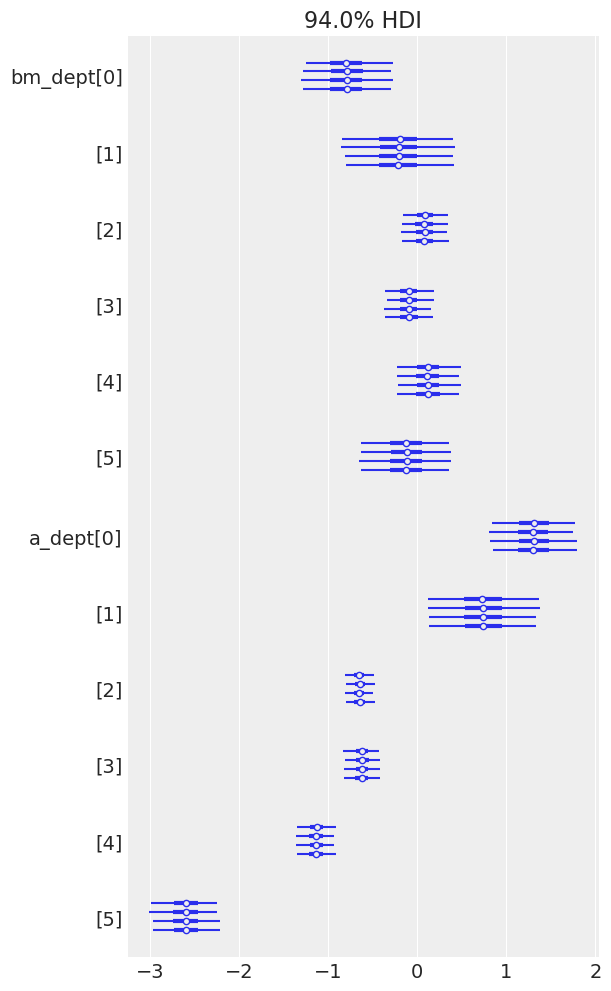

In [8]:
az.plot_forest(trace_13_3, var_names=['bm_dept', 'a_dept']);


Third model ignores gender

In [9]:
with pm.Model() as m_13_4:
    a_bar = pm.Normal('a_bar', 0, 1.5)
    sigma_dept = pm.Exponential('sigma_dept', 2)
    a_dept = pm.Normal('a_dept', a_bar, sigma_dept, shape=N_depts)
    p = pm.math.invlogit(a_dept[df['dept_id']])
    admit = pm.Binomial('admit', p=p, n=df.applications, observed=df.admit)
    
    trace_13_4 = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_dept, sigma_dept, a_bar]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 14 seconds.


In [10]:
#compare models

comp_df = az.compare({'m13_2':trace_13_2,
                      'm13_3':trace_13_3,
                      'm13_4':trace_13_4})

comp_df

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m13_3,0,-50.144679,11.416291,0.000000,4.725153e-01,2.958125,0.000000,True,log
m13_4,1,-55.028087,8.973944,4.883409,5.274847e-01,9.082585,6.806498,True,log
m13_2,2,-56.557188,11.724216,6.412509,2.442491e-15,8.037372,5.594700,True,log


# 2) Bangladesh dataset: model comparison